In [1]:
from EmuLP import Cosmology, Filter, Galaxy, Estimator, Extinction, Template, Analysis

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax_cosmo as jc
import jax.numpy as jnp
from jax import vmap, jit
import json, pickle
import os,sys,copy
from tqdm import tqdm
from collections import namedtuple

from scipy.interpolate import interp1d
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline as j_spline

2023-10-05 15:18:01.428732: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/nvptx_compiler.cc:497] The NVIDIA driver's CUDA version is 11.3 which is older than the ptxas CUDA version (11.4.152). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
conf_json = 'EmuLP/COSMOS2020-with-FORS2-HSC_only-jax-CC-togglePriorTrue-opa.json' # attention à la localisation du fichier !
inputs = Analysis.json_to_inputs(conf_json)

In [3]:
cosmo, z_grid, fine_z_grid, wl_grid, filters_arr, named_filts, baseTemp_arr, extlaws_dict, ebv_vals, dust_arr, wls_opa, opa_zgrid, opacity_grid, obs_arr = Analysis.load_data_for_analysis(conf_json)

Loading filters :


100%|██████████| 7/7 [00:00<00:00, 60.54it/s]


Building templates :


100%|██████████| 29/29 [00:04<00:00,  7.07it/s]


Generating dust attenuations laws :


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


Loading IGM attenuations :
Loading observations :


100%|██████████| 1000/1000 [00:00<00:00, 1734.86it/s]


In [4]:
df_res_emulp = pd.read_pickle(f"{inputs['run name']}_results.pkl")
df_res_emulp

,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2
362,0.61,0.6636,CWW_Im-id546,Prevot,0.25,22.885651
8353,0.27,0.2819,CWW_Scd-id354,Calzetti,0.15,124.288612
7547,0.21,0.2215,CWW_Im-id537,Prevot,0.20,73.361610
10402,0.65,0.6595,CWW_Im-id113,Prevot,0.20,16.253048
12425,1.35,1.0201,CWW_Scd-id532,Prevot,0.20,25.719025
...,...,...,...,...,...,...
5756,2.45,2.6639,CWW_Im-id699,Calzetti,0.30,27.289156
16455,0.73,0.7336,CWW_E-id235,Calzetti,0.10,6.527909
13692,0.63,0.9258,CWW_Scd-id268,Prevot,0.05,24.314442
3751,0.87,0.8700,CWW_Im-id113,Prevot,0.15,30.635420


In [5]:
df_res_more, outl_rate = Analysis.results_in_dataframe(conf_json, obs_arr, named_filts)
df_res_more

100%|██████████| 1000/1000 [00:19<00:00, 51.07it/s]

Outlier rate = 12.7441%


,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2,MagAB(cosmos_u_cfht),err_MagAB(cosmos_u_cfht),MagAB(cosmos_u_new),err_MagAB(cosmos_u_new),...,MagAB(hsc_zHSC),err_MagAB(hsc_zHSC),MagAB(hsc_yHSC),err_MagAB(hsc_yHSC),bias,std,Outlier,U-B,R-I,redness
362,0.61,0.6636,CWW_Im-id546,Prevot,0.25,22.885651,23.055801,0.006687,23.135086,0.006440,...,21.681114,0.006234,21.581612,0.007518,-5.360005e-02,-3.221931e-02,False,0.455261,0.429222,1.060666
8353,0.27,0.2819,CWW_Scd-id354,Calzetti,0.15,124.288612,21.736763,0.002886,21.713112,0.003039,...,19.379829,0.002413,19.226929,0.002557,-1.190002e-02,-9.283110e-03,False,0.858223,0.419388,2.046371
7547,0.21,0.2215,CWW_Im-id537,Prevot,0.20,73.361610,21.817879,0.001950,21.818497,0.002975,...,20.397652,0.003857,20.312340,0.004316,-1.150001e-02,-9.414659e-03,False,0.732582,0.199509,3.671931
10402,0.65,0.6595,CWW_Im-id113,Prevot,0.20,16.253048,23.978828,0.012547,24.000778,0.024770,...,21.858215,0.008252,21.678215,0.009633,-9.500024e-03,-5.724630e-03,False,0.587463,0.611992,0.959920
12425,1.35,1.0201,CWW_Scd-id532,Prevot,0.20,25.719025,24.346573,0.015538,24.361618,0.025074,...,22.694069,0.011409,22.185799,0.011367,3.298999e-01,1.633087e-01,True,0.492928,0.423218,1.164714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5756,2.45,2.6639,CWW_Im-id699,Calzetti,0.30,27.289156,24.917824,0.019804,25.060646,0.036556,...,23.791687,0.019078,23.761284,0.029802,-2.139000e-01,-5.838040e-02,False,0.890648,0.072914,12.215026
16455,0.73,0.7336,CWW_E-id235,Calzetti,0.10,6.527909,25.367477,0.083488,25.534828,0.119682,...,20.173088,0.003468,19.879967,0.003540,-3.600041e-03,-2.076627e-03,False,1.876450,1.335739,1.404802
13692,0.63,0.9258,CWW_Scd-id268,Prevot,0.05,24.314442,23.373314,0.007033,23.309196,0.010245,...,21.311661,0.005163,21.131180,0.005704,-2.958000e-01,-1.535985e-01,True,0.354195,0.752411,0.470746
3751,0.87,0.8700,CWW_Im-id113,Prevot,0.15,30.635420,23.422783,0.006462,23.356186,0.011524,...,21.451469,0.005597,21.319901,0.006395,-5.483627e-08,-2.932421e-08,False,0.378319,0.734573,0.515018


<AxesSubplot:xlabel='U-B', ylabel='R-I'>

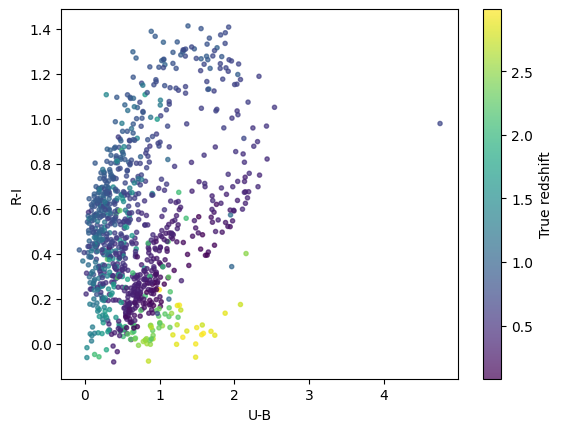

In [6]:
df_res_more.plot.scatter(x='U-B', y='R-I', c='True redshift', s=9, alpha=0.7)

<AxesSubplot:xlabel='U-B', ylabel='R-I'>

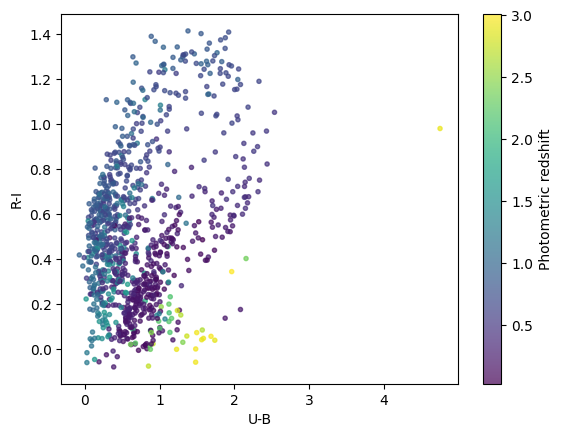

In [7]:
df_res_more.plot.scatter(x='U-B', y='R-I', c='Photometric redshift', s=9, alpha=0.7)

In [8]:
with open(f"{inputs['run name']}_results_dicts.pkl", 'rb') as handle:
    results_dict=pickle.load(handle)

In [9]:
df_res_full = pd.read_pickle(f"results_synthesis_{inputs['run name']}.pkl")
df_res_full.columns

Index(['Photometric redshift', 'True redshift', 'Template SED',
       'Extinction law', 'E(B-V)', 'Chi2', 'MagAB(cosmos_u_cfht)',
       'err_MagAB(cosmos_u_cfht)', 'MagAB(cosmos_u_new)',
       'err_MagAB(cosmos_u_new)', 'MagAB(hsc_gHSC)', 'err_MagAB(hsc_gHSC)',
       'MagAB(hsc_rHSC)', 'err_MagAB(hsc_rHSC)', 'MagAB(hsc_iHSC)',
       'err_MagAB(hsc_iHSC)', 'MagAB(hsc_zHSC)', 'err_MagAB(hsc_zHSC)',
       'MagAB(hsc_yHSC)', 'err_MagAB(hsc_yHSC)', 'bias', 'std', 'Outlier',
       'U-B', 'R-I', 'redness', 'Best SED at z_spec',
       'Best dust law at z_spec', 'E(B-V) at z_spec', 'Odd ratio',
       'Highest evidence SED', 'Highest evidence dust law',
       'Highest evidence E(B-V)', 'Highest evidence odd ratio',
       'Highest evidence z_phot (mode)', 'Highest evidence z_phot (mean)',
       'Highest evidence sigma(z)'],
      dtype='object')

In [10]:
outl_rate = 100.0*len(df_res_full[df_res_full['Outlier']])/len(df_res_full)
print(f"{len(df_res_full)} results / {len(obs_arr)} galaxies in sample")
print(f'Outlier rate = {outl_rate:.4f}%')

973 results / 1000 galaxies in sample
Outlier rate = 12.7441%


In [11]:
with open(f"{inputs['run name']}_posteriors_dict.pkl", 'rb') as handle:
    posteriors_dict=pickle.load(handle)

In [12]:
keys = list(posteriors_dict.keys())
id_test = keys[0]
posteriors_dict[id_test].keys()

dict_keys(['Full posterior', '5 most likely models', '5 best models at z_spec'])

In [13]:
df_test = pd.DataFrame(posteriors_dict[id_test]['5 most likely models'])
df_test

,Template SED,Dust law,E(B-V),zp (mode),average(z),sigma(z),median(z),Odd ratio,Bias,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),M(hsc_yHSC)
0,CWW_Im-id546,Prevot,0.25,0.60999995,0.6131862,0.0002994708,0.57,1.0,0.032219328,23.056297,23.12828,22.688316,22.149353,21.757156,21.6362,21.597618
1,CWW_Im-id699,Prevot,0.35,0.63,0.62074363,0.00011714389,0.59,0.031720534,0.020197183,23.063469,23.15699,22.663536,22.15725,21.73027,21.623474,21.632462
2,CWW_Im-id265,Prevot,0.25,0.63,0.6251134,0.00031191477,0.59,0.0006045487,0.020197183,23.028809,23.100243,22.687218,22.198875,21.772423,21.640373,21.59034
3,CWW_Im-id113,Prevot,0.05,0.54999995,0.55382586,0.00016610633,0.53,1.6535247e-05,0.06828569,23.07383,23.11866,22.77349,22.132599,21.765266,21.629677,21.55893
4,CWW_Im-id107,Prevot,0.25,0.59,0.60678077,0.0006469295,0.57,4.523008e-06,0.044241436,23.021355,23.097244,22.66436,22.184402,21.79544,21.644325,21.588211


In [14]:
df_z_spec = pd.DataFrame(posteriors_dict[id_test]['5 best models at z_spec'])
df_z_spec

,Template SED,Dust law,E(B-V),zp (mode),average(z),sigma(z),median(z),Odd ratio,Bias,M(cosmos_u_cfht),M(cosmos_u_new),M(hsc_gHSC),M(hsc_rHSC),M(hsc_iHSC),M(hsc_zHSC),M(hsc_yHSC)
0,CWW_Im-id546,Prevot,0.25,0.60999995,0.6131862,0.0002994708,0.57,1.0,0.032219328,23.069199,23.146103,22.685661,22.207962,21.736923,21.621147,21.56353
1,CWW_Im-id699,Prevot,0.35,0.63,0.62074363,0.00011714389,0.59,0.0078105736,0.020197183,23.08004,23.18325,22.660637,22.197853,21.717278,21.603546,21.598717
2,CWW_Im-id265,Prevot,0.25,0.63,0.6251134,0.00031191477,0.59,0.0028279696,0.020197183,23.03498,23.110672,22.684593,22.235237,21.759949,21.633385,21.569252
3,CWW_Im-id107,Prevot,0.25,0.59,0.60678077,0.0006469295,0.57,1.2108496e-05,0.044241436,23.038368,23.123192,22.659912,22.23507,21.776009,21.628914,21.543571
4,CWW_Im-id87,Prevot,0.1,0.57,0.5604563,0.00020036922,0.53,6.356834e-13,0.056263547,23.117233,23.145012,22.75866,22.24926,21.720818,21.599007,21.511528


In [15]:
results_summary=pd.read_pickle(f"{inputs['run name']}_results_summary.pkl")
results_summary

,Photometric redshift,True redshift,Template SED,Extinction law,E(B-V),Chi2,Highest evidence SED,Highest evidence dust law,Highest evidence E(B-V),Highest evidence odd ratio,Highest evidence z_phot (mode),Highest evidence z_phot (mean),Highest evidence sigma(z),Best SED at z_spec,Best dust law at z_spec,E(B-V) at z_spec,Odd ratio
362,0.61,0.6636,CWW_Im-id546,Prevot,0.25,22.885651,CWW_Im-id546,Prevot,0.25,1.000000,0.61,0.613186,0.000299,CWW_Im-id546,Prevot,0.25,1.000000e+00
8353,0.27,0.2819,CWW_Scd-id354,Calzetti,0.15,124.263847,CWW_Scd-id354,Calzetti,0.15,1.000000,0.27,0.269855,0.000003,CWW_Scd-id354,Calzetti,0.15,1.000000e+00
7547,0.21,0.2215,CWW_Im-id537,Prevot,0.20,73.361610,CWW_Im-id537,Prevot,0.20,1.000000,0.21,0.211476,0.000032,CWW_Im-id537,Prevot,0.20,1.000000e+00
10402,0.65,0.6595,CWW_Im-id113,Prevot,0.20,16.253048,CWW_Im-id113,Prevot,0.20,1.000000,0.65,0.644358,0.000396,CWW_Im-id113,Prevot,0.20,1.000000e+00
12425,1.35,1.0201,CWW_Scd-id532,Prevot,0.20,25.719025,CWW_Scd-id532,Prevot,0.20,1.000000,1.35,1.346265,0.000578,CWW_Im-id344,Prevot,0.25,7.343536e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5756,2.45,2.6639,CWW_Im-id699,Calzetti,0.30,27.289156,CWW_Im-id265,Prevot,0.10,1.026271,2.35,2.377516,0.003181,CWW_Im-id699,Calzetti,0.25,3.678169e-01
16455,0.73,0.7336,CWW_E-id235,Calzetti,0.10,6.527909,CWW_E-id235,Calzetti,0.10,1.000000,0.73,0.731324,0.000025,CWW_E-id235,Calzetti,0.10,1.000000e+00
13692,0.63,0.9258,CWW_Scd-id268,Prevot,0.05,24.314442,CWW_Scd-id268,Prevot,0.05,1.000000,0.63,0.630095,0.000112,CWW_Im-id537,Prevot,0.25,3.305564e-07
3751,0.87,0.8700,CWW_Im-id113,Prevot,0.15,30.635420,CWW_Im-id113,Prevot,0.15,1.000000,0.87,0.859542,0.000266,CWW_Im-id113,Prevot,0.15,1.000000e+00


In [16]:
results_enhanced, outl_rate = Analysis.enrich_dataframe(results_summary, obs_arr, named_filts)

100%|██████████| 1000/1000 [00:20<00:00, 48.21it/s]


Outlier rate = 12.7441%


In [17]:
print(f"{len(results_enhanced)} results / {len(obs_arr)} galaxies in sample")
print(f'Outlier rate = {outl_rate:.4f}%')

973 results / 1000 galaxies in sample
Outlier rate = 12.7441%


# Impact study of the median value of the the redshift distribution
In LEPHARE, using $z_{ML}$ instead of $z_{BEST}$ leads to a better outlier rate and a smoother distribution of $z_p=f(z_s)$ along the diagonal. The goal of this study is to see if it is the case here as well and try and understand why it happens.
In LEPHARE, $z_{BEST}$ is at the minimum of $\chi^2$ which might differ from the photometric redshift here.

In [22]:
for obs in tqdm(results_enhanced.index):
    z_s = results_enhanced.loc[obs, 'True redshift']
    z_p = results_enhanced.loc[obs, 'Photometric redshift']
    models_df = pd.DataFrame(posteriors_dict[obs]['5 most likely models'])
    try :
        z_ml = models_df[models_df['Odd ratio']==1]['median(z)'].values[0]
        #print(obs, z_ml)
    except IndexError:
        z_ml = models_df.loc[0, 'median(z)']
        #print(obs, z_ml, models_df.loc[0, 'Odd ratio'])
    if z_ml is None:
        z_ml = -1200.
    bias_ml = (z_ml-z_s)/(1.+z_s)
    better_ml = (np.abs(bias_ml) < np.abs(results_enhanced.loc[obs, 'bias']))
    if z_ml > 0. :
        results_enhanced.loc[obs, 'z_ML'] = z_ml
        results_enhanced.loc[obs, 'bias_ML'] = bias_ml
        results_enhanced.loc[obs, 'better_ML'] = better_ml
        results_enhanced.loc[obs, 'Outlier_ML'] = (np.abs(bias_ml) > 0.15)
    else:
        results_enhanced.loc[obs, 'z_ML'] = np.nan
        results_enhanced.loc[obs, 'bias_ML'] = np.nan
        results_enhanced.loc[obs, 'better_ML'] = False
        results_enhanced.loc[obs, 'Outlier_ML'] = True

100%|██████████| 973/973 [00:04<00:00, 231.47it/s]


In [23]:
outl_rate_ml = 100.0*len(results_enhanced[results_enhanced['Outlier_ML']])/len(results_enhanced)
print(f'Outlier rate = {outl_rate_ml:.4f}%')

Outlier rate = 21.5827%


Text(0.5, 0.98, 'EmuLP on COSMOS2020 subset, Outliers rate=12.744%, z_ML outliers rate=21.583%')

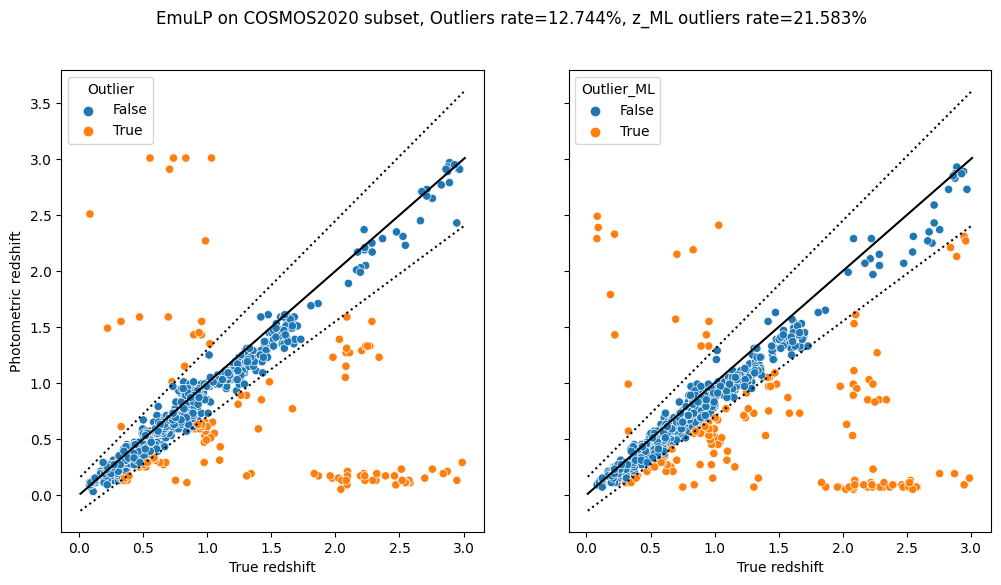

In [30]:
f,a = plt.subplots(1,2,figsize=(12,6), sharey=True)
a=a.ravel()
sns.scatterplot(data=results_enhanced, x='True redshift', y='Photometric redshift', hue='Outlier', ax=a[0])
sns.scatterplot(data=results_enhanced, x='True redshift', y='z_ML', hue='Outlier_ML', ax=a[1])
a[0].plot(z_grid, z_grid, c='k')
a[0].plot(z_grid, z_grid+0.15*(1+z_grid), c='k', ls=':')
a[0].plot(z_grid, z_grid-0.15*(1+z_grid), c='k', ls=':')
a[1].plot(z_grid, z_grid, c='k')
a[1].plot(z_grid, z_grid+0.15*(1+z_grid), c='k', ls=':')
a[1].plot(z_grid, z_grid-0.15*(1+z_grid), c='k', ls=':')
f.suptitle(f"EmuLP on COSMOS2020 subset, Outliers rate={outl_rate:.3f}%, z_ML outliers rate={outl_rate_ml:.3f}%")